#**Training Sequential Model**
Here, we will train the sequential model and tune the hyperparameters to get better results. 

##Importing Libraries

In [ ]:
from keras.models import model_from_json, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from pickle import load, dump
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


##Downloading Image Dataset

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!unzip Flickr8k_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: Flicker8k_Dataset/3429641260_2f03

##Loading Files
We will now load all the files that our saved in other notebooks and that are required for training the final model.

In [ ]:
with open("train_image_encodings.pkl", "rb") as f:
  train_image_encodings = load(f)

with open("train_captions.pkl", "rb") as f:
  train_captions = load(f)

with open("tokenizer.pkl", "rb") as f:
  tokenizer = load(f)

with open("model.json", "r") as f:
  model = model_from_json(f.read())

In [ ]:
#Loading the saved weights
model.load_weights("model.h5")
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 39, 300)      706500      input_9[0][0]                    
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 2048)         0           input_8[0][0]                    
____________________________________________________________________________________________

In [ ]:
#Defining the generator function as discussed in the pre-processing notebook
def Generator(captions, img_encoding, max_length, dict_size, num_photos_per_batch):
  X1, X2, Y = list(), list(), list()
  n = 0
  while(1):
    for id, caption_list in captions.items():
      n += 1
      img = img_encoding[id]
      for caption in caption_list:
        sequence = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(sequence)):
          inp_sequence, out_sequence = sequence[:i], sequence[i]
          inp_sequence = pad_sequences([inp_sequence], maxlen = max_length, padding = 'post')[0]
          out_sequence = to_categorical([out_sequence], num_classes = dict_size)[0]
          X1.append(img)
          X2.append(inp_sequence)
          Y.append(out_sequence)
      if(n==num_photos_per_batch):
        yield [[np.array(X1), np.array(X2)], np.array(Y)]
        X1, X2, Y = list(), list(), list()
        n = 0 

In [ ]:
#Declaring global variables
max_length = 39
dict_size = 2355
target_size = (299, 299, 3)
embedding_size = 300
epochs = 20
num_images_per_batch = 5
steps = len(train_captions)//num_images_per_batch

##Training

In [ ]:
#Training the model for 20 epochs with batch_size as 5
for i in range(epochs):
  generator = Generator(train_captions, train_image_encodings, max_length, dict_size, num_images_per_batch)
  model.fit_generator(generator, steps_per_epoch = steps)
  model.save("model_epoch" + str(i) + ".h5")

Epoch 1/1
1200/1200 [==============================] - 1332s 1s/step - loss: 3.8194
Epoch 1/1
1200/1200 [==============================] - 1295s 1s/step - loss: 3.0972
Epoch 1/1
1200/1200 [==============================] - 1276s 1s/step - loss: 2.8654
Epoch 1/1
1200/1200 [==============================] - 1253s 1s/step - loss: 2.7233
Epoch 1/1
1200/1200 [==============================] - 1297s 1s/step - loss: 2.6161
Epoch 1/1
1200/1200 [==============================] - 1290s 1s/step - loss: 2.5320
Epoch 1/1
1200/1200 [==============================] - 1300s 1s/step - loss: 2.4611
Epoch 1/1
1200/1200 [==============================] - 1351s 1s/step - loss: 2.4006
Epoch 1/1
1200/1200 [==============================] - 1349s 1s/step - loss: 2.3504
Epoch 1/1
1200/1200 [==============================] - 1380s 1s/step - loss: 2.3063
Epoch 1/1
1200/1200 [==============================] - 1406s 1s/step - loss: 2.2697
Epoch 1/1
1200/1200 [==============================] - 1404s 1s/step - loss:

In [ ]:
#Loading the weights as generated in the last epoch of previous training process
model.load_weights("model_epoch19.h5")

#Tuning the hyperparameters
num_images_per_batch = 10
steps = len(train_captions)//num_images_per_batch
epochs = 5
"""We will reduce the learning rate to 0.0001 and batch_size to 10. During 
   the later stages of training, since the model is moving towards convergence, 
   we must lower the learning rate so that we take smaller steps towards the 
   minima. Also increasing the batch size over time helps gradient updates 
   to be more powerful."""
model.optimizer.learning_rate = 0.0001

#Training it for 5 epochs
for i in range(epochs):
  generator = Generator(train_captions, train_image_encodings, max_length, dict_size, num_images_per_batch)
  model.fit_generator(generator, steps_per_epoch = steps)
  #model.save("model_epoch2" + str(i) + ".h5")

Epoch 1/1
600/600 [==============================] - 1412s 2s/step - loss: 2.0456
Epoch 1/1
600/600 [==============================] - 1409s 2s/step - loss: 1.9943
Epoch 1/1
600/600 [==============================] - 1403s 2s/step - loss: 1.9766
Epoch 1/1
600/600 [==============================] - 1396s 2s/step - loss: 1.9638
Epoch 1/1
600/600 [==============================] - 1401s 2s/step - loss: 1.9531


In [ ]:
model.save_weights("epoch24.h5")

#Reducing the learning rate to 0.00001 and training it for 5 more epochs
num_images_per_batch = 10
steps = len(train_captions)//num_images_per_batch
epochs = 5
model.optimizer.learning_rate = 0.00001
for i in range(epochs):
  generator = Generator(train_captions, train_image_encodings, max_length, dict_size, num_images_per_batch)
  model.fit_generator(generator, steps_per_epoch = steps)
  #model.save("model_epoch2" + str(i) + ".h5")

Epoch 1/1
600/600 [==============================] - 1389s 2s/step - loss: 1.9444
Epoch 1/1
600/600 [==============================] - 1392s 2s/step - loss: 1.9383
Epoch 1/1
600/600 [==============================] - 1405s 2s/step - loss: 1.9295
Epoch 1/1
600/600 [==============================] - 1404s 2s/step - loss: 1.9227
Epoch 1/1
600/600 [==============================] - 1392s 2s/step - loss: 1.9167


In [ ]:
#Saving the final model weights
model.save_weights("model_epoch29.h5")

In [ ]:
model.load_weights("model_epoch29.h5")

In [ ]:
#Redefining the inceptionV3 model as done in pre-processing phase so that we can test the model on test set
incep = InceptionV3(weights = 'imagenet')
incep.layers.pop()
for layer in incep.layers:
  layer.trainable = False

inception = Model(inputs = incep.inputs, outputs = incep.layers[-1].output)
print(inception.summary())

96116736/96112376 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
___________________________

##Defining Functions

In [ ]:
#Redefining the function as declared in pre-processing phase, that encodes a PIL image into image encodings that can be fed into the model as input
def encode_img(id, model):
  img = load_img("{}".format(id), target_size = (299, 299))
  img_ar = img_to_array(img)
  img_dim = np.expand_dims(img_ar, axis = 0)
  img_ = preprocess_input(img_dim)
  predict = model.predict(img_)
  predict = predict.reshape(predict.shape[1])
  #print(predict.shape)
  return np.array(predict)

## Greedy Approach for Decoding the Caption 

In [ ]:
#Loading word_to_idx dictionary and idx_to_word dictionary which were pickled in pre-processing phase 
with open("word_to_idx", "rb") as f:
  word_to_idx = load(f)

with open("idx_to_word", "rb") as f:
  idx_to_word = load(f)

#Function that calls encode_image function to generate image encodings and also predicts the caption of the image
def predict_caption(id):
  encoded_img = np.expand_dims(encode_img(id, inception), axis = 0)
  text = 'startseq'
  for i in range(max_length):
    #Splitting the caption generated uptill now into words
    sequence = [word_to_idx[word] for word in text.split() if word in word_to_idx] 
    #Padding the sequence of words to the length of max_length by adding 0's at the end
    sequence = np.expand_dims(pad_sequences([sequence], maxlen = max_length, padding = "post")[0], axis = 0)
    #Predicting the captionword by word
    y_hat = model.predict([encoded_img, sequence], verbose = 0)
    #Selecting the index with maximum probabilty in the prediction generated
    y_hat = np.argmax(y_hat)
    #Converting the index into word using idx_to_word dictionary
    word = idx_to_word[y_hat]
    #Adding the predicted word into final caption 
    text += ' ' + word
    #Words are generated untill 'endseq' is encountered
    if word == 'endseq':
      break
  return text

## Beam Search for Decoding the Caption

In [ ]:
def beam_search(id, beam):
  encoded_img = np.expand_dims(encode_img(id, inception), axis = 0)
  start = [word_to_idx['startseq']]
  start_word = [[start,0.0]]
  while len(start_word[0][0]) < max_length:
    temp = []
    for s in start_word:
      #Padding the sequence of words to the length of max_length by adding 0's at the end
      sequence = np.expand_dims(pad_sequences([s[0]], maxlen = max_length, padding = "post")[0], axis = 0)
      #Predicting the captionword by word
      y_hat = model.predict([encoded_img, sequence], verbose = 0)
      sorting_word_pred = np.argsort(y_hat[0])[-beam:]
      for w in sorting_word_pred:
        caption, prob = s[0][:], s[1]
        caption.append(w)
        prob += np.log(y_hat[0][w])
        temp.append([caption, prob])

    start_word = temp
    start_word = sorted(start_word, key = lambda l : l[1])
    start_word = start_word[-beam:]
  start_word = start_word[-1][0]
  cap = [idx_to_word[i] for i in start_word]
  caption = []
  for i in cap:
    if i=='endseq':
      break 
    caption.append(i)
  caption = ' '.join(caption[1:])
  return caption

##Testing Using Greedy Approach
Now, we will test our model on images in the test set.

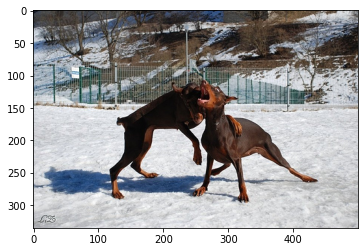

Caption:   a brown dog is running in the snow 


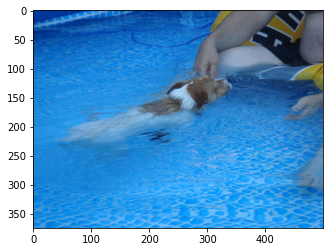

Caption:   a woman in a tutu is throwing a ball into a swimming pool 


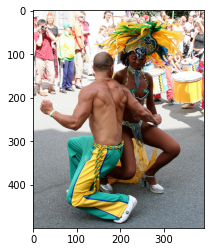

Caption:   a man in a black shirt is standing in front of a crowd of people 


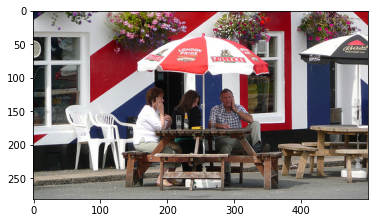

Caption:   a man in a green shirt is sitting on a stool in front of a large office 


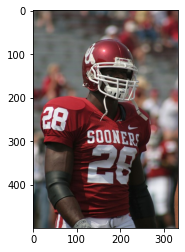

Caption:   a football player in a red and white uniform is being tackled by a player in red 


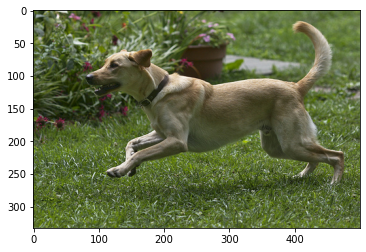

Caption:   a brown dog is running through a grassy area 


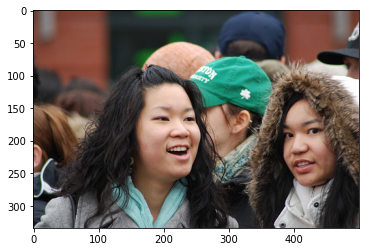

Caption:   a woman in a pink sweater is smiling while standing in front of a crowd 


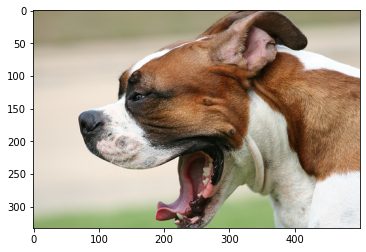

Caption:   a brown and white dog is running through the grass 


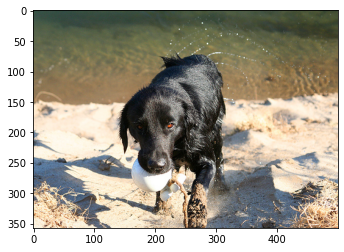

Caption:   a black dog is running through the water 


In [ ]:
with open("Flickr_8k.testImages.txt", "r") as f:
  test_images = f.read()

#We will test the first 10 images in the test set 
i = 0
for line in test_images.split("\n"):
  i += 1
  id = line.split('.')[0]
  img = plt.imread("Flicker8k_Dataset/{}.jpg" .format(id))
  plt.imshow(img)
  plt.show()
  pred = predict_caption("Flicker8k_Dataset/{}.jpg" .format(id))
  print("Caption: ", pred[8:-6])
  if(i==9):
    break

## Testing Using Beam Search 

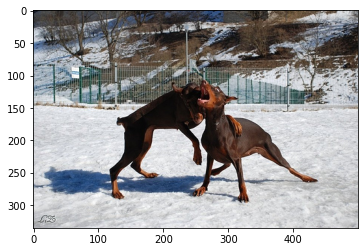

Caption:  a brown dog and a brown dog are fighting in the snow


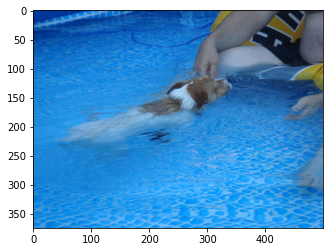

Caption:  a girl in a pink bathing suit jumps into a swimming pool


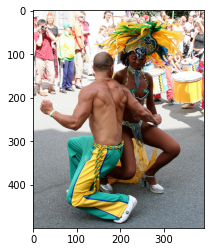

Caption:  a man in a black shirt is standing in front of a crowd of people


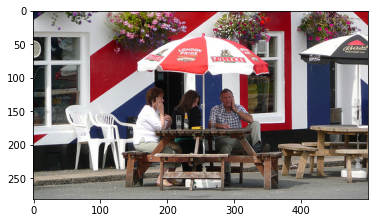

Caption:  a group of people sit on a bench in front of a restaurant


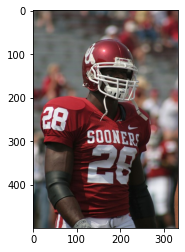

Caption:  a football player wearing a red sooners jersey is being lifted by a player in white


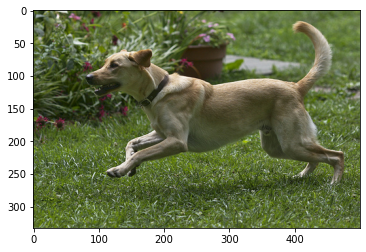

Caption:  a brown dog is running through the grass


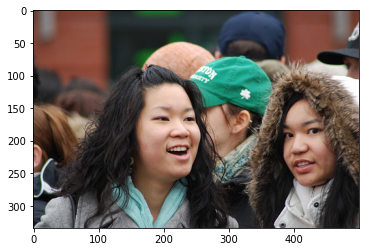

Caption:  a group of people are posing for a picture


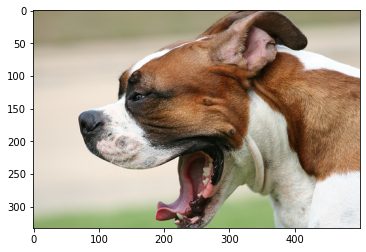

Caption:  a brown and white dog is running through the grass


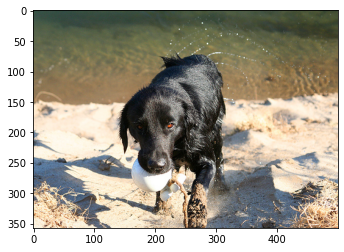

Caption:  a black and white dog is running through the water


In [ ]:
with open("Flickr_8k.testImages.txt", "r") as f:
  test_images = f.read()

#We will test the first 10 images in the test set 
i = 0
for line in test_images.split("\n"):
  i += 1
  id = line.split('.')[0]
  img = plt.imread("Flicker8k_Dataset/{}.jpg" .format(id))
  plt.imshow(img)
  plt.show()
  pred = beam_search("Flicker8k_Dataset/{}.jpg" .format(id), 3)
  print("Caption: ", pred[:])
  if(i==9):
    break

##Testing the Model on Personal Image

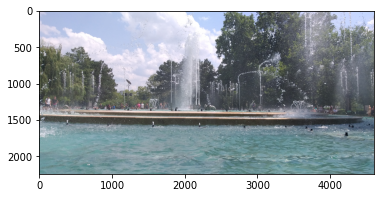

Caption:   a man in a blue shirt is standing in a shallow river 


In [ ]:
#Greedy Search
img = plt.imread("20190619_130754.jpg")
plt.imshow(img)
plt.show()
pred = predict_caption("20190619_130754.jpg")
print("Caption: ", pred[8:-6])

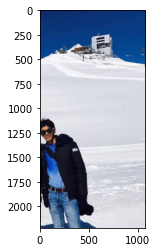

Caption:   a man in a blue jacket is standing on a snowy plain 


In [ ]:
#Greedy Search
img = plt.imread("Screenshot_20200722-171024_Gallery.jpg")
plt.imshow(img)
plt.show()
pred = predict_caption("Screenshot_20200722-171024_Gallery.jpg")
print("Caption: ", pred[8:-6])

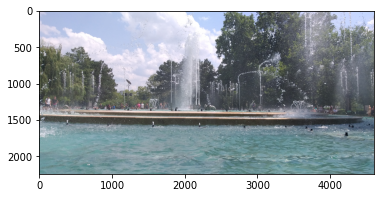

Caption:  a dog is swimming in a lake


In [ ]:
#Beam Search
img = plt.imread("20190619_130754.jpg")
plt.imshow(img)
plt.show()
pred = beam_search("20190619_130754.jpg", 5)
print("Caption: ", pred[:])

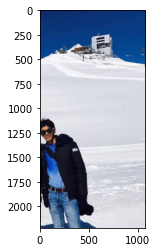

Caption:  a hiker stops up a snowy mountain


In [ ]:
#Beam Search
img = plt.imread("Screenshot_20200722-171024_Gallery.jpg")
plt.imshow(img)
plt.show()
pred = beam_search("Screenshot_20200722-171024_Gallery.jpg", 5)
print("Caption: ", pred[:])